In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk

In [2]:
# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
add_stop = ['said', 'say', '...', 'like', 'cnn', 'ad']
stop_words = ENGLISH_STOP_WORDS.union(add_stop)

# List of punctuation
punc = list(set(string.punctuation))


# Splits words on white spaces (leaves contractions intact) and splits out trailing punctuation
def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens


def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)


def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]
    text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text


def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  


def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)


def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens


# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist


def word_count(text):
    return len(str(text).split(' '))

In [3]:
df = pd.read_csv('bbc_news.csv')
print(df.shape)
df.head()

(10364, 5)


title  \
0  Ukraine: Angry Zelensky vows to punish Russian...   
1  War in Ukraine: Taking cover in a town under a...   
2         Ukraine war 'catastrophic for global food'   
3  Manchester Arena bombing: Saffie Roussos's par...   
4  Ukraine conflict: Oil price soars to highest l...   

                         pubDate  \
0  Mon, 07 Mar 2022 08:01:56 GMT   
1  Sun, 06 Mar 2022 22:49:58 GMT   
2  Mon, 07 Mar 2022 00:14:42 GMT   
3  Mon, 07 Mar 2022 00:05:40 GMT   
4  Mon, 07 Mar 2022 08:15:53 GMT   

                                               guid  \
0  https://www.bbc.co.uk/news/world-europe-60638042   
1  https://www.bbc.co.uk/news/world-europe-60641873   
2      https://www.bbc.co.uk/news/business-60623941   
3            https://www.bbc.co.uk/news/uk-60579079   
4      https://www.bbc.co.uk/news/business-60642786   

                                                link  \
0  https://www.bbc.co.uk/news/world-europe-606380...   
1  https://www.bbc.co.uk/news/world-europe-606418...   
2  https://www.bbc.co.uk/news/business-60623941?a...   
3  https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4  https://www.bbc.co.uk/news/business-60642786?a...   

                                         description  
0  The Ukrainian president says the country will ...  
1  Jeremy Bowen was on the frontline in Irpin, as...  
2  One of the world's biggest fertiliser firms sa...  
3  The parents of the Manchester Arena bombing's ...  
4  Consumers are feeling the impact of higher ene...

In [4]:
df1 = df[['title', 'description']]
df1.head()

title  \
0  Ukraine: Angry Zelensky vows to punish Russian...   
1  War in Ukraine: Taking cover in a town under a...   
2         Ukraine war 'catastrophic for global food'   
3  Manchester Arena bombing: Saffie Roussos's par...   
4  Ukraine conflict: Oil price soars to highest l...   

                                         description  
0  The Ukrainian president says the country will ...  
1  Jeremy Bowen was on the frontline in Irpin, as...  
2  One of the world's biggest fertiliser firms sa...  
3  The parents of the Manchester Arena bombing's ...  
4  Consumers are feeling the impact of higher ene...

In [5]:
# Get the word count
df1['word_count'] = df1['description'].apply(word_count)
df1['word_count'].mean()

C:\Users\73660\AppData\Local\Temp/ipykernel_5748/1368670480.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['word_count'] = df1['description'].apply(word_count)


17.483018139714396

In [6]:
# Process the text
df1['processed_text'] = df1['description'].apply(process_text)
df1.head()

C:\Users\73660\AppData\Local\Temp/ipykernel_5748/1787289112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['processed_text'] = df1['description'].apply(process_text)


title  \
0  Ukraine: Angry Zelensky vows to punish Russian...   
1  War in Ukraine: Taking cover in a town under a...   
2         Ukraine war 'catastrophic for global food'   
3  Manchester Arena bombing: Saffie Roussos's par...   
4  Ukraine conflict: Oil price soars to highest l...   

                                         description  word_count  \
0  The Ukrainian president says the country will ...          16   
1  Jeremy Bowen was on the frontline in Irpin, as...          18   
2  One of the world's biggest fertiliser firms sa...          17   
3  The parents of the Manchester Arena bombing's ...          16   
4  Consumers are feeling the impact of higher ene...          16   

                                      processed_text  
0  [ukrainian, presid, countri, forgiv, forget, m...  
1  [jeremi, bowen, frontlin, irpin, resid, came, ...  
2  [world, biggest, fertilis, firm, conflict, del...  
3  [parent, manchest, arena, bomb, youngest, vict...  
4  [consum, feel, impact, higher, energi, cost, f...

In [7]:
# Descriptive statistics for word count
df1['word_count'].describe()

count    10364.000000
mean        17.483018
std          3.839816
min          6.000000
25%         15.000000
50%         17.000000
75%         19.000000
max         45.000000
Name: word_count, dtype: float64

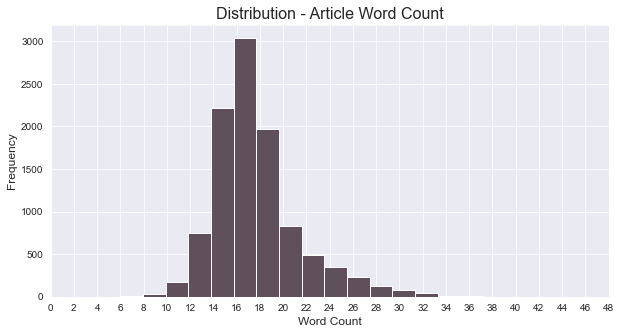

In [8]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(10,5))

plt.hist(
    df1['word_count'],
    bins=20,
    color='#60505C'
)

plt.title('Distribution - Article Word Count', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Count', fontsize=12)
plt.yticks(np.arange(0, 3500, 500))
plt.xticks(np.arange(0, 50, 2))

plt.show()

In [9]:
# Get the top 20 most common words among all the articles
p_text = df1['processed_text']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20

word  frequency
0   england        613
1    ukrain        549
2      year        549
3     peopl        528
4       bbc        525
5       new        506
6        uk        481
7     world        466
8       win        447
9       day        400
10    leagu        370
11  russian        358
12   russia        354
13    women        304
14     citi        295
15    final        281
16     time        276
17     help        276
18   govern        264
19     home        261

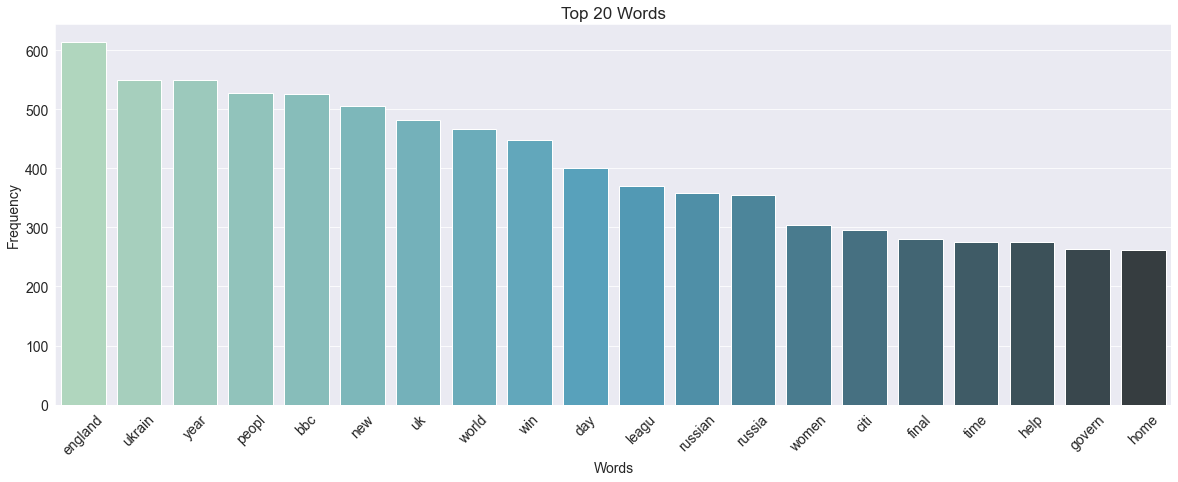

In [10]:
# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)

plt.show()

In [11]:
# Get the number of unique words after processing
num_unique_words = len(set(p_text))
num_unique_words

11669

In [12]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df1['processed_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

In [13]:
# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 200, 10))

# Run the nmf model and calculate the coherence score for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

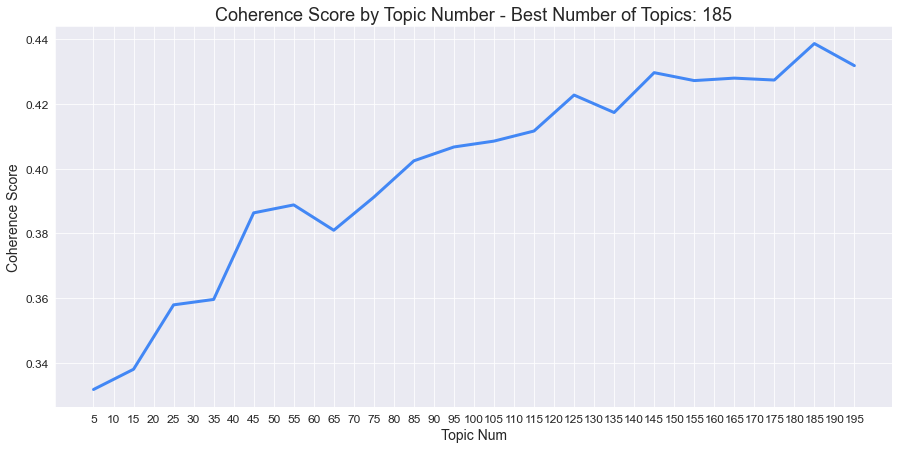

In [14]:
# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [16]:
# Now use the number of topics with the highest coherence score to run the sklearn nmf model

texts = df1['processed_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

In [18]:
# Use the top words for each cluster by tfidf weight to create 'topics'

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()

0                   1             2             3            4  \
0   world  world championship       largest  world number         titl   
1     win               award          gold          titl      victori   
2   close          pay attent     close pay        attent  attent past   
3  minist               prime  prime minist           mps       resign   
4     old            year old          year    three year        three   

              5               6              7  \
0  championship  world champion  world largest   
1   england win       award win       win gold   
2     seven day      past seven           past   
3     new prime        uk prime   leader prime   
4     nine year         old man      suspicion   

                                            topics  
0  world championship largest number titl champion  
1              win award gold titl victori england  
2                  close pay attent past seven day  
3            minist prime mps resign new uk leader  
4                old year three nine man suspicion

In [19]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df.head()

topic_num                                           topics
0          0  world championship largest number titl champion
1          1              win award gold titl victori england
2          2                  close pay attent past seven day
3          3            minist prime mps resign new uk leader
4          4                old year three nine man suspicion

In [75]:
# Creating a temp df with the link and topic num to join on
link = df['link'].tolist()

df_temp = pd.DataFrame({
    'link': link,
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

print(merged_topic.shape)
merged_topic.head()

(10364, 3)


link  topic_num  \
0  https://www.bbc.co.uk/news/world-europe-606380...         29   
1  https://www.bbc.co.uk/news/world-europe-606418...        124   
2  https://www.bbc.co.uk/news/business-60623941?a...          0   
3  https://www.bbc.co.uk/news/uk-60579079?at_medi...        178   
4  https://www.bbc.co.uk/news/business-60642786?a...        119   

                                            topics  
0  presid ukrain zelenski putin ukrainian ex biden  
1             tri escap help franc peopl score war  
2  world championship largest number titl champion  
3        young peopl speak care men princess voter  
4              price food soar increas energi rise

In [76]:
# Showing the 3 matrices we get witn nmf
A = tfidf_vectorizer.transform(texts)
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

A = 10364 x 5000
W = 185 x 5000
H = 10364 x 185


In [77]:
# Get the residuals for each document
r = np.zeros(A.shape[0])

for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), 'fro')

sum_sqrt_res = round(sum(np.sqrt(r)), 3)
'Sum of the squared residuals is {}'.format(sum_sqrt_res)

'Sum of the squared residuals is 9601.445'

In [83]:
# Add the residuals to the df
merged_topic['resid'] = r

# Get the avg residual by topic
resid_data = merged_topic[[
    'topic_num',
    'resid'
]].groupby('topic_num').mean().sort_values(by='resid')

In [85]:
print(resid_data[resid_data.resid == resid_data.resid.min()])

              resid
topic_num          
16         0.393208


In [89]:
df2 = merged_topic[merged_topic.topic_num == 16]
print(df2.shape)
df2
#Topic #16 has the lowest residual and therefore means the topic approximates the text the the best 
#There are 42 articles that belong to that topic

(42, 4)


link  topic_num  \
245    https://www.bbc.co.uk/news/technology-60700642...         16   
312    https://www.bbc.co.uk/news/in-pictures-6069986...         16   
494    https://www.bbc.co.uk/news/business-60241966?a...         16   
622    https://www.bbc.co.uk/news/in-pictures-6079349...         16   
925    https://www.bbc.co.uk/news/in-pictures-6086395...         16   
1220   https://www.bbc.co.uk/news/in-pictures-6094191...         16   
1505   https://www.bbc.co.uk/news/in-pictures-6103896...         16   
1797   https://www.bbc.co.uk/news/in-pictures-6109828...         16   
1990   https://www.bbc.co.uk/news/world-us-canada-611...         16   
2025   https://www.bbc.co.uk/news/world-europe-605066...         16   
2041   https://www.bbc.co.uk/news/in-pictures-6119001...         16   
2288   https://www.bbc.co.uk/news/world-europe-612491...         16   
2311   https://www.bbc.co.uk/news/in-pictures-6126055...         16   
2602   https://www.bbc.co.uk/news/in-pictures-6134854...         16   
2892   https://www.bbc.co.uk/news/in-pictures-6143949...         16   
2981   https://www.bbc.co.uk/news/world-europe-614720...         16   
3174   https://www.bbc.co.uk/news/in-pictures-6152433...         16   
3485   https://www.bbc.co.uk/news/in-pictures-6160795...         16   
4065   https://www.bbc.co.uk/news/in-pictures-6174838...         16   
4338   https://www.bbc.co.uk/news/in-pictures-6183342...         16   
4627   https://www.bbc.co.uk/news/in-pictures-6191649...         16   
4873   https://www.bbc.co.uk/news/uk-wales-62018267?a...         16   
5191   https://www.bbc.co.uk/news/in-pictures-6209120...         16   
5461   https://www.bbc.co.uk/news/in-pictures-6218218...         16   
5509   https://www.bbc.co.uk/news/uk-wales-62152869?a...         16   
5545   https://www.bbc.co.uk/news/uk-wales-62152869?a...         16   
5731   https://www.bbc.co.uk/news/in-pictures-6226513...         16   
6026   https://www.bbc.co.uk/news/in-pictures-6233634...         16   
6158   https://www.bbc.co.uk/news/uk-england-norfolk-...         16   
6346   https://www.bbc.co.uk/news/in-pictures-6242099...         16   
6649   https://www.bbc.co.uk/news/in-pictures-6251810...         16   
6748   https://www.bbc.co.uk/news/uk-scotland-edinbur...         16   
6961   https://www.bbc.co.uk/news/in-pictures-6257642...         16   
7211   https://www.bbc.co.uk/news/in-pictures-6268607...         16   
7468   https://www.bbc.co.uk/news/in-pictures-6276661...         16   
8489   https://www.bbc.co.uk/news/science-environment...         16   
8564   https://www.bbc.co.uk/news/in-pictures-6307447...         16   
8767   https://www.bbc.co.uk/news/uk-scotland-tayside...         16   
8839   https://www.bbc.co.uk/news/in-pictures-6317134...         16   
9055   https://www.bbc.co.uk/news/uk-scotland-scotlan...         16   
9153   https://www.bbc.co.uk/news/in-pictures-6326177...         16   
10045  https://www.bbc.co.uk/news/in-pictures-6351435...         16   

                                   topics     resid  
245    taken globe imag past select power  0.880158  
312    taken globe imag past select power  0.064840  
494    taken globe imag past select power  0.849917  
622    taken globe imag past select power  0.064840  
925    taken globe imag past select power  0.064840  
1220   taken globe imag past select power  0.064840  
1505   taken globe imag past select power  0.064840  
1797   taken globe imag past select power  0.514185  
1990   taken globe imag past select power  0.996152  
2025   taken globe imag past select power  0.891957  
2041   taken globe imag past select power  0.514185  
2288   taken globe imag past select power  0.898838  
2311   taken globe imag past select power  0.064840  
2602   taken globe imag past select power  0.064840  
2892   taken globe imag past select power  0.064840  
2981   taken globe imag past select power  0.971607  
3174   taken globe imag past select power  0.064840  
3485   taken globe imag pa